In [1]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using Optim
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using QuantileRegressions
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction


# Access the matplotlib module
matplotlib = pyimport("matplotlib")
mpl_inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
seaborn = pyimport("seaborn")
pyimport("scienceplots")

np = pyimport("numpy")
skl_model_selection = pyimport("sklearn.model_selection")
seaborn.color_palette("colorblind")

PyCall.pygui(:tk)

# Set a seed for reproducibility
using Random
Random.seed!(11);

In [2]:
matplotlib.style.use(["default","science","no-latex"])

plt = pyimport("matplotlib")
SIZE=21
FONTSIZE=21
DOTCOLOR="green"
EDGECOLOR="gray"
plt.style.use(["default","science","no-latex"])

In [31]:
#Returns means, upper, and lower quntailes for a single year's prediction from a single (R, yr_calibrated) pair
function calculate_quantiles_mean(sample, row)
    slice = sample[row, :]
    mean_data = mean(slice)
    quantile_5 = quantile(slice, 0.05)
    quantile_95 = quantile(slice, 0.95)
    
    return mean_data, quantile_5, quantile_95

end

calculate_quantiles_mean (generic function with 1 method)

In [32]:
all_years_no_gap = collect(range(2016, step=1, length=285))
yrs_gapped = collect(range(2030, step=15, length=19));

yrs_dict = Dict{Int64, Int64}()
for (idx,yr) in enumerate(all_years_no_gap)
        yrs_dict[yr] = idx
end

In [33]:
function plot_trajectorys(iter, selections, axis, x_values, y_values, present_value, face_color)
    all_y = vcat([present_value], y_values)
    axis.plot(x_values, all_y, marker = "o", markersize= 6.6, color="black", ls="dashed",
        markerfacecolor=face_color, label = iter == selections[1] ? "Individual scenario" : "_nolegend_")
 
end

plot_trajectorys (generic function with 2 methods)

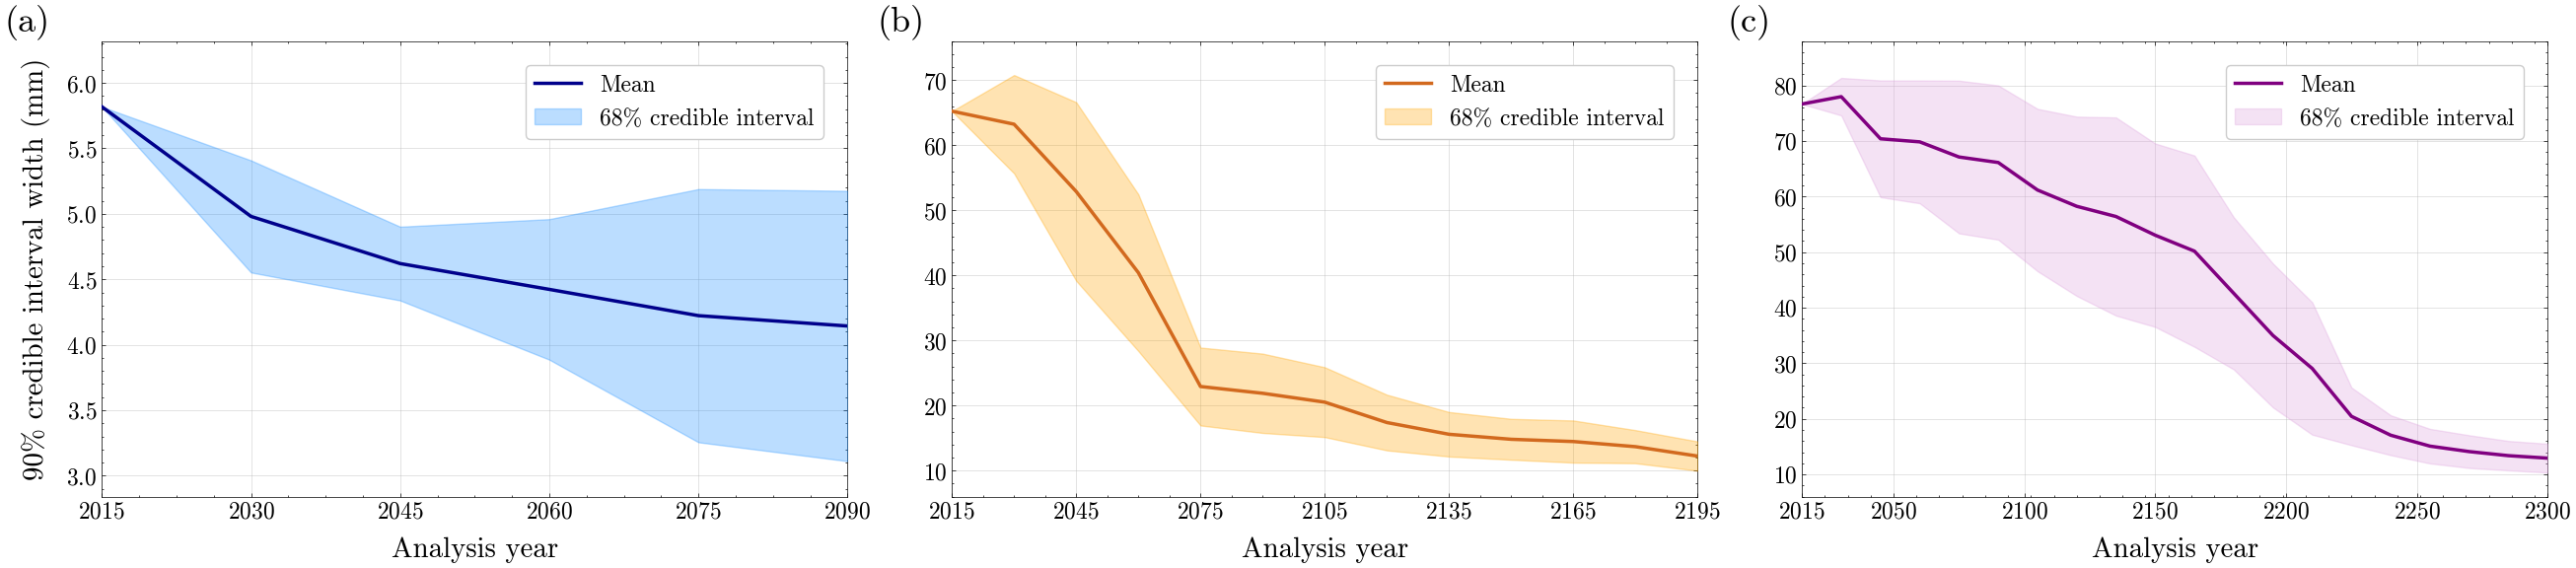

In [35]:
### FIGURE 4 Plotting Script
#Change this path to "Data/Projection_Data" once you have run the previous PCA Projection setting on your posteriors
path_to_projections = "../Data/Projection_Data"

#Realization numbers
realizations = [string(i) for i in 1:100];

color_dict = Dict(
                2100 => "darkblue", 2200=> "chocolate", 2300=>"purple"
)

fill_color_dict = Dict(
                2100 => "dodgerblue", 2200=> "orange", 2300=>"plum"
)

xticks_dict = Dict(2100 => [2015,2030,2045,2060,2075,2090], 
                   2200 => [2015,2045,2075,2105,2135,2165,2195], 
                   2300 => [2015,2050,2100,2150,2200,2250,2300])

yticks_dict = Dict(2100 => [3,3.5,4,4.5,5,5.5,6],
                   2200 => [10,20,30,40,50,60,70],
                   2300 => [10,20,30,40,50,60,70,80])

ylim_dict = Dict(2100 => [2.84,6.32],
                 2200 => [6,76],
                 2300 => [6,88])

selections = [13,27,40,45,58,70,78]



# fig, ax = subplots(nrows=1, ncols=1, figsize=(10.5, 8))
fig, axes = subplots(nrows=1, ncols=3, figsize=(32, 6))
fig.subplots_adjust(wspace=0.14, hspace=0.0) 

FONTSIZE=26
output_file_name = "../Plots/SLR_Learning_Plots/Without_Trajectories/slr_learning_plot.pdf"


letters = ["a", "b", "c"]
for (a,chosen_year) in enumerate([2100, 2200, 2300])
    ax = axes[a]

    #Corresponding row in the matrix of projections
    row_idx = yrs_dict[chosen_year]
    n_cal_years = fld(chosen_year-2015,15) + 1
    full_yr_range = collect(range(2015, step=15, length= n_cal_years ))
    
    #Get 2015 projections upper and lower quantile bounds
    present2015_post_mm_ssp5 = JLD2.load("../Data/Projection_Data/2015_SLR_Projections.jld2", "present2015_post_mm_ssp5")
    present_mu, present_lower, present_upper, = calculate_quantiles_mean(present2015_post_mm_ssp5, row_idx)
    present_width = present_upper - present_lower
    
    #Vector to hold the widths of each trajectory, for averaging purposes later
    total_widths = zeros(100,length(full_yr_range))
    for (iter,realization) in enumerate(realizations)
        one_trajectorys_widths = Vector{Float64}()
        #loop through the years at which calibrations occur
        for yr in full_yr_range[2:end]
            #load projections matrix 
            vaf_sample = JLD2.load("$(path_to_projections)/R_$(realization)/$(realization)-year$(yr)pred_VAF.jld2",
                "sample_post_mm_ssp5")
            mu, lower, upper, = calculate_quantiles_mean(vaf_sample, row_idx)
            push!(one_trajectorys_widths, upper - lower)
        end
        #UNCOMMENT LINE BELOW TO ADD TRJAECTORIES TO PLOT
        if iter in selections
            # plot_trajectorys(iter, selections, ax, full_yr_range, one_trajectorys_widths, present_width, color_dict[chosen_year])
        end
        total_widths[iter,:] = vcat(present_width, one_trajectorys_widths)
    end

    #Calculate averages and standard deviations across trajectories
    mean_widths = vec( mean(total_widths, dims=1) )
    std_widths = vec( std(total_widths, dims=1) )
    upper = mean_widths .+ std_widths
    lower = mean_widths .- std_widths
    ax.plot(full_yr_range, mean_widths, color=color_dict[chosen_year],lw=2.5,label="Mean", zorder = 500)
    ax.fill_between(full_yr_range, upper,lower, color=fill_color_dict[chosen_year],alpha = 0.3, label="68% credible interval", zorder = 499)
    
    ax.set_xlabel("Analysis year", fontsize= FONTSIZE*0.8, labelpad=10)
    if a == 1
        ax.set_ylabel("90% credible interval width (mm)", fontsize= FONTSIZE*0.8, labelpad=12)
    end
    ax.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.65)
    ax.set_xlim(2015,full_yr_range[n_cal_years])
    ax.set_ylim(ylim_dict[chosen_year])
    ax.set_xticks(xticks_dict[chosen_year])
    ax.set_yticks(yticks_dict[chosen_year])
    ax.grid(true, alpha=0.5, zorder=1)
    
    handles, labels = ax.get_legend_handles_labels()
    n = length(handles)
    desired_indices = filter(i -> 1 ≤ i ≤ n, [1,2,3]) 
    sorted_handles = [handles[i] for i in desired_indices]
    sorted_labels = [labels[i] for i in desired_indices]
    if a == 1
        ax.text(-0.13, 1.08, "(" * letters[a] * ")", ha="left", va="top", transform=ax.transAxes, fontsize=FONTSIZE)
    else
        ax.text(-0.1, 1.08, "(" * letters[a] * ")", ha="left", va="top", transform=ax.transAxes, fontsize=FONTSIZE)
    end
    ax.legend(sorted_handles, sorted_labels, loc="lower center", ncol=1, fontsize=FONTSIZE*0.65,
        # bbox_to_anchor=(0.772, 0.712), frameon="True", framealpha=1)
       bbox_to_anchor=(0.768, 0.76), frameon="True", framealpha=1)
end

mkpath(dirname(output_file_name))
fig.savefig(output_file_name; bbox_inches="tight", dpi=300) 